In [117]:
import numpy as np 
from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astroquery.vizier import Vizier
import seaborn as sns

In [118]:
sns.set_context("talk")
sns.set_color_codes()

In [119]:
datapath = Path.cwd().parent / "data"

# Get celestial coordinates of proplyd sources

List of proplyds that we will work with:

In [169]:
proplyd_ids = [
    "177-341W",
    "180-331",
]

## Coordinates from SIMBAD (not accurate enough)

Use SIMBAD name service to get the coordinates of each source

In [104]:
cdict = {
    _: SkyCoord.from_name(f"[RRS2008] {_}")
    for _ in proplyd_ids
}

In [105]:
cdict

{'177-341w': <SkyCoord (ICRS): (ra, dec) in deg
     (83.82363747, -5.39468523)>,
 '180-331': <SkyCoord (ICRS): (ra, dec) in deg
     (83.82518623, -5.39187077)>}

In [107]:
cdict["177-341W"].to_string("hmsdms")

'05h35m17.67299252s -05d23m40.86682307s'

Even though we use the Ricci catalog ID to find the source, the SIMBAD coordinates _do not come from that catalog_. As a result, they are inaccurate by of order 0.2 arcsec, so we cannot use them

## Coordinates from Ricci 2008 catalog via Vizier

Get the coordinates of all proplyds in the first table of the catalog. Add the `Name` column as an index, so we can more efficiently look up individual sources. 

In [188]:
proplyd_tab = Vizier(
    catalog="J/AJ/136/2136",
    columns=['Name', '_RAJ2000', '_DEJ2000'],
    row_limit=-1,
).get_catalogs(    
    catalog="J/AJ/136/2136",
)[0]
proplyd_tab.add_index("Name")

Restrict to just the sources that we want:

In [189]:
proplyd_tab = proplyd_tab.loc[proplyd_ids]

If we make minor modifications to the RA, Dec column names, then `SkyCoord.guess_from_table()` can do its magic. Then we can remove the original columns. 

In [190]:
proplyd_tab.rename_columns(['_RAJ2000', '_DEJ2000'], ["ra_J2000", "dec_J2000"])
proplyd_tab["ICRS"] = SkyCoord.guess_from_table(proplyd_tab)
proplyd_tab.remove_columns(["ra_J2000", "dec_J2000"])

In [191]:
proplyd_tab

Name,ICRS
,"deg,deg"
str9,SkyCoord
177-341W,"83.8235833,-5.3947222"
180-331,"83.825125,-5.3918889"


# Look at image of some sources

In [215]:
fname = "f631n"
hdu = fits.open(datapath / f"align-pcmos-{fname}_sharp_16.fits")[0]

In [216]:
W = WCS(hdu.header)

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


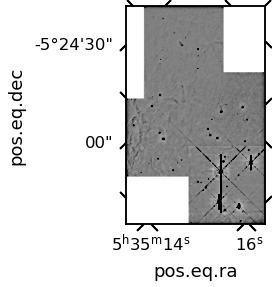

In [217]:
source = "177-341W"
#source = "180-331"
x0, y0 = proplyd_tab.loc[source]["ICRS"].to_pixel(W)
fig, ax = plt.subplots(subplot_kw=dict(projection=W))
ax.imshow(hdu.data, vmin=0, vmax=2, cmap="gray_r")

So, using imshow we always have the x, y axes aligned with the pixeaxes of the imegae. 

If we want to have it aligned with equatorial axes, then we will have to define an auxiliary WCS and then use pcolormesh instead of imshow.



In [218]:
ny, nx = 100, 100
pixscale = Angle("0.05 arcsec").deg
c = proplyd_tab.loc[source]["ICRS"]
wc = WCS(naxis=2)
wc.wcs.cdelt = [-pixscale, pixscale]
wc.wcs.crval = [c.ra.deg, c.dec.deg]
wc.wcs.crpix = [0.5 * (1 + nx), 0.5 * (1 + ny)]
wc.wcs.ctype = ["RA---TAN", "DEC--TAN"]

In [219]:
wc

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.8235833  -5.3947222  
CRPIX : 50.5  50.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.388888888888889e-05  1.388888888888889e-05  
NAXIS : 0  0

Now, we use upper case for the pixel coords and celestial coords of the big image grid

In [220]:
NY, NX = hdu.data.shape
X, Y = np.meshgrid(np.arange(NX), np.arange(NY))
CPIX = W.pixel_to_world(X, Y)

So CPIX is an array of same shape as hdu.data that contains celestial coordinates.

Check that if we convert them to pixels in our little aux frame that we have some near the origin

In [221]:
np.sum(np.hypot(*CPIX.to_pixel(wc)) < 50)

9608

[(0.0, 100.0), (0.0, 100.0)]

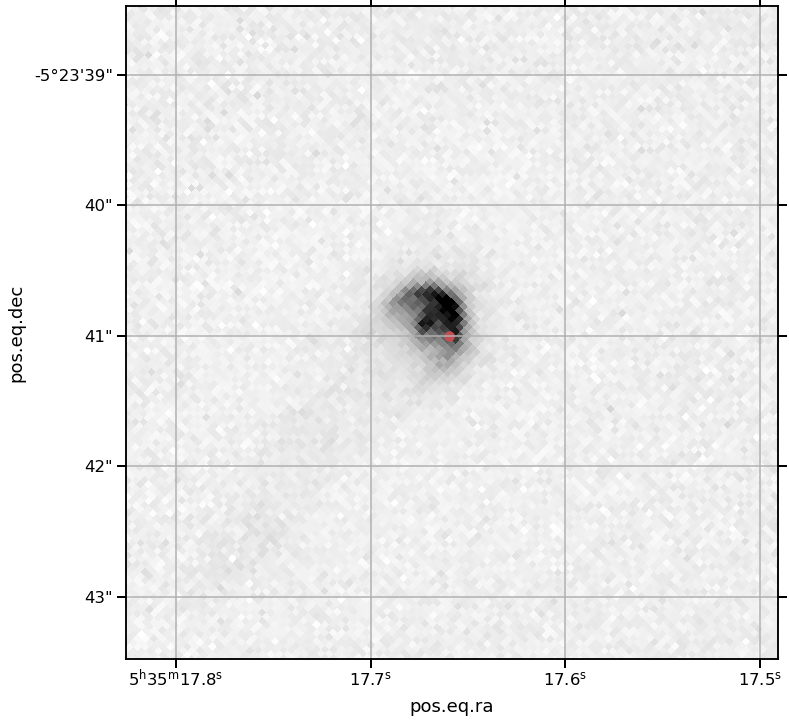

In [222]:
fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw=dict(projection=wc),
)
T = ax.get_transform("world")
ax.pcolormesh(
    CPIX.ra.deg,
    CPIX.dec.deg,
    hdu.data, 
    vmin=0, 
    vmax=15, 
    cmap="gray_r",
    shading="nearest",
    transform=T,
)
ax.scatter(c.ra.deg, c.dec.deg, transform=T, color='r')
ax.set_aspect("equal")
ax.set(
    xlim=[0, nx],
    ylim=[0, ny],
)

In [229]:
proplyd_tab.loc[source]["ICRS"].to_string("hmsdms")

'05h35m17.659992s -05d23m40.99992s'

In [ ]:
proplyd_tab.loc[source]["ICRS"].to_string

In [56]:
ax.pcolormesh?

Signature:
ax.pcolormesh(
    *args,
    alpha=None,
    norm=None,
    cmap=None,
    vmin=None,
    vmax=None,
    shading=None,
    antialiased=False,
    data=None,
    **kwargs,
)
Docstring:
Create a pseudocolor plot with a non-regular rectangular grid.

Call signature::

    pcolormesh([X, Y,] C, **kwargs)

*X* and *Y* can be used to specify the corners of the quadrilaterals.

.. hint::

   `~.Axes.pcolormesh` is similar to `~.Axes.pcolor`. It is much faster
   and preferred in most cases. For a detailed discussion on the
   differences see :ref:`Differences between pcolor() and pcolormesh()
   <differences-pcolor-pcolormesh>`.

Parameters
----------
C : array-like
    A scalar 2-D array. The values will be color-mapped.

X, Y : array-like, optional
    The coordinates of the corners of quadrilaterals of a pcolormesh::

        (X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                              +-----+
                              |     |
                      